# [Explaining and Harnessing Adversarial Examples](http://arxiv.org/abs/1412.6572)

This paper has three main contributions: 

- We argue that the primary cause of neural networks’ vulnerability to adversarial perturbation is their **linear nature**.
- This view yields a simple and fast method of **generating adversarial examples**. Using this approach to provide examples for adversarial training, we reduce the test set error of a maxout network on the MNIST dataset.
- We show that **adversarial training** can provide an additional regularization benefit beyond that provided by using dropout alone. Generic regularization strategies such as dropout, pretraining, and model averaging do not confer a significant reduction in a model’s vulnerability to adversarial examples, but changing to nonlinear model families such as RBF networks can do so.

Our explanation suggests a fundamental tension between **designing models that are easy to train due to their linearity** and **designing models that use nonlinear effects to resist adversarial perturbation**. In the long run, it may be possible to escape this tradeoff by designing more powerful optimization methods that can succesfully train more nonlinear models.

This explanation is supported by new quantitative results while giving the first explanation of the most intriguing fact about them: their generalization across architectures and training sets. 

A popular approach in computer vision is to use convolutional network features as a space where Euclidean distance approximates perceptual distance. This resemblance is clearly flawed if images that have **an immeasurably small perceptual distance** correspond to **completely different classes** in the network’s representation.


## THE LINEAR EXPLANATION OF ADVERSARIAL EXAMPLES

We start with explaining the existence of adversarial examples for linear models.

Formally, for problems with well-separated classes, we expect the classifier to assign the same class to $x$ and  $\tilde{x} = x + η$  so long as  $||η||_{∞} < \epsilon$, where $\epsilon$ is small enough to be discarded by the sensor or data storage apparatus associated with our problem.

Consider the dot product between a weight vector $w$ and an adversarial example $\tilde{x}$:
$$
w^{T} \tilde{x} = w^{T} x + w^{T}η
$$

We can maximize this increase subject to the max norm constraint on $η$ by assigning $η$ = sign($w$).

If $w$ has $n$ dimensions and the average magnitude of an element of the weight vector is $m$, then the activation will grow by $\epsilon mn$.

Since $||η||_{∞}$ does not grow with the dimensionality of the problem but the change in activation caused by perturbation by $η$ can grow linearly with $n$, then for **high dimensional** problems, we can make many infinitesimal changes to the input that add up to one large change to the output. 

We can think of this as a sort of “accidental steganography,” where a linear model is forced to attend exclusively to the signal that aligns most closely with its weights, even if multiple signals are present and other signals have much greater amplitude.

This explanation shows that a simple linear model can have adversarial examples if its input has sufficient dimensionality. Our hypothesis based on linearity is simpler, and can also explain why softmax regression is vulnerable to adversarial examples.

## LINEAR PERTURBATION OF NON-LINEAR MODELS

Let $θ$ be the parameters of a model, $x$ the input to the model, $y$ the targets associated with $x$ (for machine learning tasks that have targets) and $J(θ, x, y)$ be the cost used to train the neural network. We can linearize the cost function around the current value of $θ$ , obtaining an optimal max-norm constrained pertubation of

$$
η = \epsilon sign (∇_{x}J(θ, x, y))
$$

We refer to this as the “**fast gradient sign method**” of generating adversarial examples. Note that the required gradient can be computed efficiently using backpropagation.

In [25]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = True

In [26]:
eps_1 = 0.007

In [27]:
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [28]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

def image_folder_custom_label(root, transform, custom_label) :

    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(custom_label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = custom_label
    new_data.class_to_idx = label2idx

    return new_data

In [29]:
normal_data = image_folder_custom_label(root = './data/', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [30]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


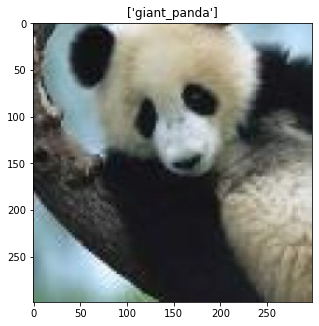

In [31]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

In [32]:
device = torch.device("cuda" if use_cuda else "cpu")

In [33]:
model_1 = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT).to(device)
# model_1 = models.googlenet(pretrained=True).to(device)

True Image & Predicted Label


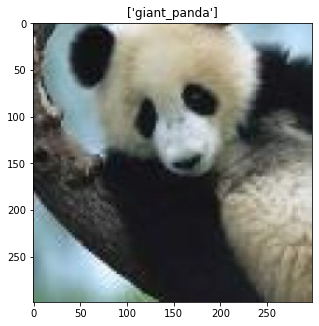

83.370739 % confidence
Accuracy of test text: 100.000000 %


In [39]:
print("True Image & Predicted Label")

model_1.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_1(images)

    outputs = nn.functional.softmax(outputs, dim=1)
    
    con, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    print('%f %% confidence' % (con.item()*100))
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

In [40]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

In [41]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


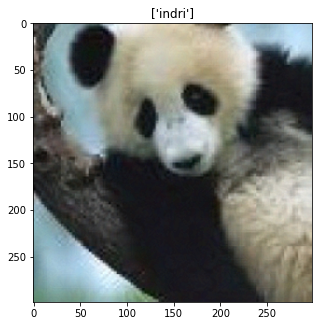

73.624229 % confidence
Accuracy of test text: 0.000000 %


In [42]:
print("Attack Image & Predicted Label")

model_1.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = fgsm_attack(model_1, loss, images, labels, eps_1).to(device)
    labels = labels.to(device)
    outputs = model_1(images)

    outputs = nn.functional.softmax(outputs, dim=1)
    
    con, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    print('%f %% confidence' % (con.item()*100))
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

The fact that these simple, cheap algorithms are able to generate misclassified examples serves as evidence in favor of our interpretation of adversarial examples as a result of **linearity**. The algorithms are also useful as a way of speeding up adversarial training or even just analysis of trained networks.

## ADVERSARIAL TRAINING OF LINEAR MODELS VERSUS WEIGHT DECAY

If we train a single model to recognize labels $y ∈ \{−1, 1\}$ with $P (y = 1) = σ (w^{T}x + b)$ where $σ(z)$ is the logistic sigmoid function, then training consists of gradient descent on
$$
\mathbb{E}_{x,y∼p_{data}} ζ(−y(w^{T}x + b))
$$

where $ζ(z) = log (1 + exp(z))$ is the softplus function.

Note that the sign of the gradient is just $−sign(w)$, and that $w^{T}sign(w) = ||w||_{1}$. The adversarial version of logistic regression is therefore to minimize
$$
\mathbb{E}_{x,y∼p_{data}} ζ(y(\epsilon||w||_{1} − w^{T}x − b))
$$

This is somewhat similar to $L^{1}$ regularization. However, there are some important differences. 

Most significantly, the $L^{1}$ penalty is subtracted off the model’s activation during training, rather than added to the training cost. 

This means that the penalty can eventually start to disappear if the model learns to make confident enough predictions that $ζ$ saturates. 

This is not guaranteed to happen—in the underfitting regime, adversarial training will simply worsen underfitting. We can thus view $L^{1}$ weight decay as **being more “worst case” than adversarial training**, because it fails to deactivate in the case of good margin.

If we move beyond logistic regression to multiclass softmax regression, $L^{1}$ weight decay becomes even more pessimistic, because it treats each of the softmax’s outputs as independently perturbable, when in fact it is usually not possible to find a single $η$ that aligns with all of the class’s weight vectors. 

**Weight decay overestimates the damage achievable with perturbation** even more in the case of a deep network with multiple hidden units. Because $L^{1}$ weight decay overestimates the amount of damage an adversary can do, it is necessary to use a smaller $L^{1}$ weight decay coefficient than the $\epsilon$ associated with the precision of our features.

## ADVERSARIAL TRAINING OF DEEP NETWORKS

Shallow linear models are not able to become constant near training points while also assigning different outputs to different training points.

Of course, the universal approximator theorem does not say anything about whether a training algorithm will be able to discover a function with all of the desired properties. Obviously, standard supervised training does not specify that the chosen function be resistant to adversarial examples. This must be encoded in the training procedure somehow.

We found that training with an adversarial objective function based on the fast gradient sign method was an effective regularizer:
$$
\tilde{J}(θ, x, y) = αJ(θ, x, y) + (1 − α)J(θ, x + \epsilon sign (∇_{x}J(θ, x, y))
$$

In all of our experiments, we used $α = 0.5$. Other values may work better; our initial guess of this hyperparameter worked well enough that we did not feel the need to explore more. This approach means that we continually update our supply of adversarial examples, to make them resist the current version of the model.

In [ ]:
mnist_train = dset.MNIST('../Intriguing properties of neural networks/data', train=True, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
mnist_test = dset.MNIST('../Intriguing properties of neural networks/data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)